# Reading radar files

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyart
import pylab as pl
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
filename='MVOL/SAO160604230003.RAWM96D'
radar=pyart.io.read(filename)
print radar.fields.keys()

['differential_phase', 'cross_correlation_ratio', 'spectrum_width', 'total_power', 'reflectivity', 'differential_reflectivity', 'specific_differential_phase', 'velocity']


/usr/local/lib/python2.7/dist-packages/pyart/io/sigmet.py:141: UserWarning: File truncated or corrupt, 1 of 2 sweeps read
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


In [3]:
gatefilter=pyart.correct.moment_based_gate_filter(radar,min_refl=0.,min_rhv=0.8)
gatefilter.exclude_outside(field='differential_reflectivity',v1=-2.,v2=6.)
gatefilter.exclude_outside(field='velocity',v1=-50.,v2=50.)

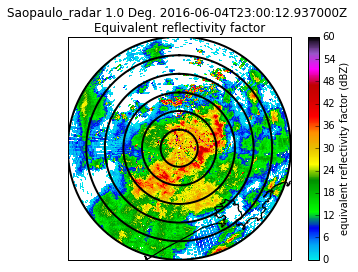

In [4]:
display=pyart.graph.RadarMapDisplay(radar)

display.plot_ppi_map('reflectivity', resolution='h',vmin=0.,vmax=60.,gatefilter=gatefilter)
display.plot_range_rings([10, 20, 30, 40 ,50 ,60])
display.plot_cross_hair(5.)

spec_at, cor_z = pyart.correct.calculate_attenuation(radar, 0)
radar.add_field('specific_attenuation', spec_at)
radar.add_field('corrected_reflectivity_horizontal', cor_z)


/usr/local/lib/python2.7/dist-packages/pyart/retrieve/qpe.py:167: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  kdp[kdp < 0] = 0.


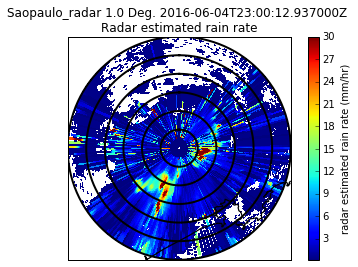

In [5]:
rain=pyart.retrieve.est_rain_rate_zkdp(radar,alphaz=0.15,betaz=0.39,alphakdp=19.63,betakdp=0.823,master_field='reflectivity')
#rain=pyart.retrieve.est_rain_rate_z(radar,alpha=0.15,beta=0.39)
radar.add_field(field_name='rainrate',dic=rain,replace_existing=True)

display=pyart.graph.RadarMapDisplay(radar)

display.plot_ppi_map('rainrate', resolution='h',vmin=0.2,vmax=30.,gatefilter=gatefilter)
display.plot_range_rings([10, 20, 30, 40 ,50 ,60])
display.plot_cross_hair(5.)

In [6]:
import wradlib as wrl
from wradlib.trafo import idecibel

In [7]:
dz=radar.get_field(field_name='reflectivity',sweep=0)

In [8]:
rz=wrl.zr.z2r(idecibel(dz))

In [9]:
radar.add_field_like(field_name='rainrate_z',existing_field_name='rainrate',data=rz )

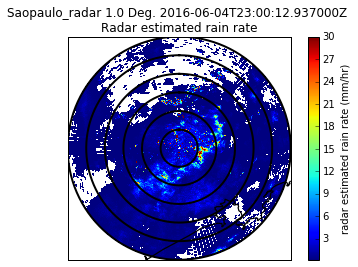

In [10]:
display=pyart.graph.RadarMapDisplay(radar)

display.plot_ppi_map('rainrate_z', resolution='h',vmin=0.2,vmax=30.,gatefilter=gatefilter)
display.plot_range_rings([10, 20, 30, 40 ,50 ,60])
display.plot_cross_hair(5.)

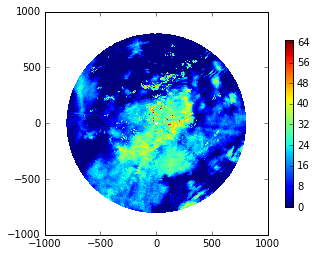

In [11]:
ax,pm=wrl.vis.plot_ppi(dz,vmin=0.,vmax=65.)
cbar = pl.colorbar(pm, shrink=0.75)

/usr/lib/python2.7/dist-packages/matplotlib/transforms.py:2764: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  elif vmax - vmin <= maxabsvalue * tiny:


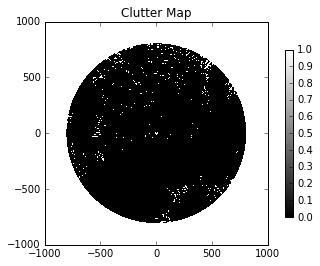

In [12]:
data=dz
clutter = wrl.clutter.filter_gabella(data, tr1=12, n_p=6, tr2=1.1)
pl.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(clutter, cmap=pl.cm.gray)
pl.title('Clutter Map')
cbar = pl.colorbar(pm, shrink=0.75)

/usr/local/lib/python2.7/dist-packages/wradlib/ipol.py:1039: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  filled_data[clutter_indices] = filling.astype(filled_data.dtype)


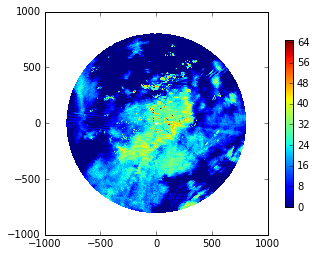

In [13]:
data_no_clutter = wrl.ipol.interpolate_polar(data, clutter)
pl.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_no_clutter,vmin=0.,vmax=65.) # simple diagnostic plot
cbar = pl.colorbar(pm, shrink=0.75)

In [14]:
pia = wrl.atten.correctAttenuationKraemer(data_no_clutter)
data_attcorr = data_no_clutter + pia

/usr/lib/python2.7/dist-packages/numpy/ma/core.py:6432: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


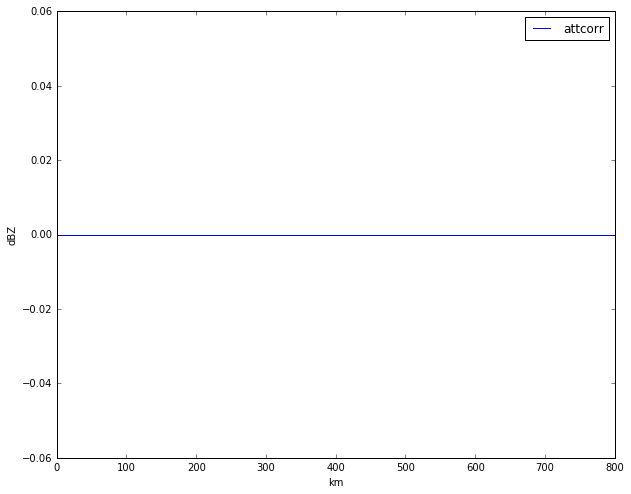

In [15]:
pl.figure(figsize=(10,8))
pl.plot(pia[65], label="attcorr")
pl.xlabel("km")
pl.ylabel("dBZ")
pl.legend()

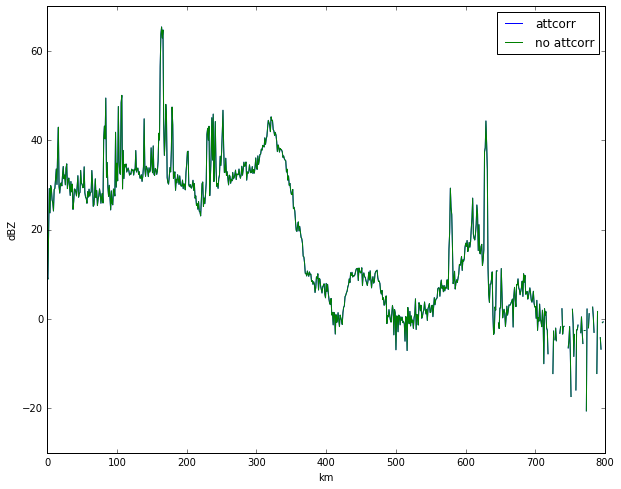

In [16]:
pl.figure(figsize=(10,8))
pl.plot(data_attcorr[65], label="attcorr")
pl.plot(data_no_clutter[65], label="no attcorr")
pl.xlabel("km")
pl.ylabel("dBZ")
pl.legend()

In [17]:
sweep_times = wrl.util.from_to("2012-10-26 00:00:00", "2012-10-27 00:00:00", 300)
depths_5min = np.random.uniform(size=(len(sweep_times)-1, 360, 128))
hours = wrl.util.from_to("2012-10-26 00:00:00", "2012-10-27 00:00:00", 3600)
depths_hourly = wrl.util.aggregate_in_time(depths_5min, sweep_times, hours, func='sum')

In [18]:
print(depths_hourly.shape)
print(depths_hourly.mean().round())

(24, 360, 128)
6.0


ValueError: too many values to unpack

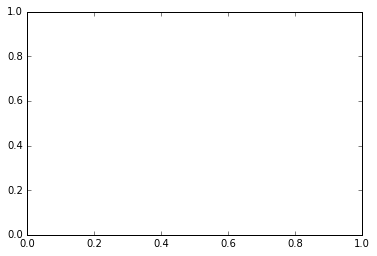

In [19]:
pl.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(depths_5min) # simple diagnostic plot
cbar = pl.colorbar(pm, shrink=0.75)

In [30]:
print type(rain['data'])

<class 'numpy.ma.core.MaskedArray'>
